In [1]:
# https://github.com/alexmohelsky/dtsa-5510-project/blob/main/w5-project.ipynb
# 
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import tensorflow as tf
from keras.datasets import mnist
import time

from sklearn.metrics import accuracy_score, confusion_matrix

# Some project setup code taken from 
# define font sized s to make the figures pretty
# https://colab.research.google.com/github/ageron/handson-ml3/blob/main/17_autoencoders_gans_and_diffusion_models.ipynb#scrollTo=8d4TH3NbpKzx

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")
else:
    print("GPU device detected")
        


/home/alexmohelsky/anaconda3/envs/PythonGPU/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2022-12-06 17:53:09.673238: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 17:53:09.944478: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-06 17:53:09.984218: W tensorflow/compiler/xla/stream_executor/pla

No GPU was detected. Neural nets can be very slow without a GPU.


2022-12-06 17:53:11.976972: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 17:53:11.977920: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2022-12-06 17:53:11.977976: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2022-12-06 17:53:11.978012: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file o

## 1. Introduction

While CCNs have been used in computer image recongnition since the 1980s, in the last 10 years A.I. complex visual tasks performance has increased dramatically due to advanced in computional power as well as deep learning techniques, A.I. This project explores deep computer vision using convolutional neural networks (CNN), i.e. deep learning, using the MNIST image data, both for unsupervised learning using autoencoders and comparing that performance to supervised deep learning. The project is organized into Exploratory Data Analytics (EDA), supervised learning techniques, unsuperised deep learning, comparing the performance of these two techniques, discussing the pros and cons of the two appoaches, and then ends with a conclusion. Note that preprocessing is a little different based on the models that are being used, so the data preprocessing is discussed in each modeling section.

## 2. Exploratory Data Analysis (EDA)

EDA shows that the training set has 60,000 images. Each image is a 28 x 28 pixel grayscale image. The values in the data set range from 0 to 255. These value will have to be normalized or standardized. Examining the y_train data shows that there are 10 classes labelled 0 to 9.



In [3]:
# importing the dataset from keras

mnist = tf.keras.datasets.fashion_mnist.load_data()
(x_train, y_train), (x_test, y_test) = mnist


In [4]:
# EDA
print(type(x_train))
print(type(x_test))
print(type(y_train))
print(type(y_test))

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


# Checking the minimum and maximum values of x_train
print(x_train.min())
print(x_train.max())
print(x_train.mean())




<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)
0
255
72.94035223214286


<Figure size 640x480 with 0 Axes>

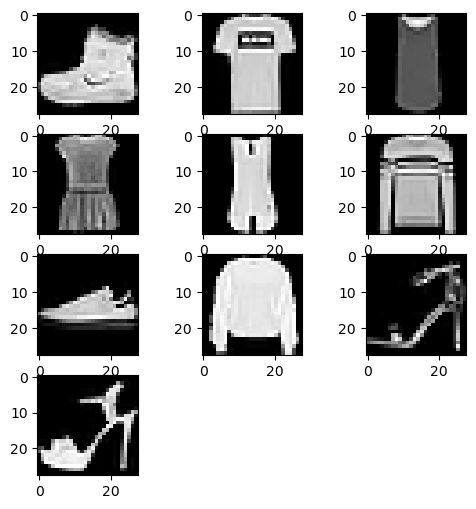

In [5]:
plt.gray() # B/W Images
plt.figure(figsize = (6,6)) # Adjusting figure size
# Displaying a grid of 3x3 images
for i in range(10):
 plt.subplot(4,3,i+1)
 plt.imshow(x_train[i])

In [6]:
print(y_train)
print(np.max(y_train))
print(np.min(y_train))

[9 0 0 ... 3 0 5]
9
0


The code above shows there are 10 possible classes.

## 3. Image Classifcation using Supervised Learning

Two supervised learning approaches are used. The first uses Scikit-Learns Logistic Regression to base line supervised learning performance. Logist Regression Classifier is a very simple model and therefore always serves as a good comparator against more complex models. If it does just was well or better, then there is not need for a more complex model that also might be less explainable. Accuracy scores amd confusion matrices are geenrated for the Logistic Regression models. The second is TensorFlows CNN which is widely recognized as one of the best options for deep learning especially for images. Data preprocing for each is slightly different and is explained in each subsection.

### 3.1 Logistic Regression

Scikit-Learn's "MNIST classification using multinomial logistic + L1" example is the reference, however, there are signficant differences and so the code is very different from the well known example:

- MNIST Fashion data is used which is more complex than the very well known MNIST "hand written digits" data that is used in the example. 

- Two data preprocessing techniques are used. We will experiment with two normalization techniques: Scitkit-Learn's StandardScaler (this is show in the reference Scikit-Learn example) and then forcing each value to be between 0 and 1 (this is shown in the Kers/Tensflow example). The question that is trying to be answered is to see to see which pre-processing technique yields better results since both example took a different approach (i.e. the two approach are being combined and compared here). Other small difference are noted in the comments in the following code cells. 

- The same logicst regeression classifier hyperparamters in the referenced example are used to see if one preprocessing works better than the other.

- Scikit-Learn's GridSearchCSV is used to perform hyper parameter tuning to enourage getting the best possible performance out of Scikit-Learns Logistic Regression Classifier. This is done for both data preprocessing techniques


In [7]:
# here we convert from 3 dimensions to 2
x_train_logit = x_train.reshape((x_train.shape[0], -1))
x_test_logit = x_test.reshape((x_test.shape[0], -1))
print(x_train_logit.shape)
print(x_test_logit.shape)
scaler = StandardScaler()
#x_train_logit = scaler.fit_transform(x_train_logit)
#x_test_logit = scaler.transform(x_test_logit)

# default split of 25% is test / hold out data is being used
xtr, xtst, ytr, ytst = train_test_split( x_train_logit, y_train)
xtr = scaler.fit_transform(xtr)
xtst = scaler.fit_transform(xtst)
x_test_logit = scaler.fit_transform(x_test_logit)

# Checking the minimum, maximum, and mean values of x_train to compare against the originals 
# shown in the EDA section

print(xtr.min())
print(xtr.max())
print(xtr.mean())





(60000, 784)
(10000, 784)
-2.406991724283392
161.8909397703184
-9.409454822764139e-19


In [9]:
t0 = time.time()
# code it take from 
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html#sphx-glr-auto-examples-linear-model-plot-sparse-logistic-regression-mnist-py
# Turn up tolerance for faster convergence
clf = LogisticRegression(C=1, penalty="l1", solver="saga", tol=0.1)
clf.fit(xtr, ytr)
#sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(xtst, ytst)

print("Test score with L1 penalty: %.4f" % score)
run_time = time.time() - t0
print(run_time)

Test score with L1 penalty: 0.8355
10.88614535331726


In [10]:
preds = clf.predict(x_test_logit)
print(accuracy_score(y_test, preds))

0.8221


In [ ]:
print(confusion_matrix(y_test, preds))

In [11]:
parameters = {'penalty':('l1', 'l2', 'none'), 'C':[1, .8, .6, .4, .2], 
              'tol':[0.1],
              'solver': ['lbfsgs', 'sag', 'saga']}

model = LogisticRegression()

clf = GridSearchCV(model, parameters)
clf.fit(xtr, ytr)
score = clf.score(xtst, ytst)
print("GridSearchCV Test score: %.4f" % score)
print(clf.best_params_)
run_time = time.time() - t0

/home/alexmohelsky/anaconda3/envs/PythonGPU/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/alexmohelsky/anaconda3/envs/PythonGPU/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/alexmohelsky/anaconda3/envs/PythonGPU/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/alexmohelsky/anaconda3/envs/PythonGPU/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/alexmohelsky/anaconda3/envs/PythonGPU/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1

GridSearchCV Test score: 0.8461
{'C': 0.8, 'penalty': 'l2', 'solver': 'sag', 'tol': 0.1}


In [17]:
preds = clf.predict(x_test_logit)
print(accuracy_score(y_test, preds))

0.8286


In [13]:
print(confusion_matrix(y_test, preds))


[[802   4  11  58   7   5 101   0  12   0]
 [  5 949   5  32   6   0   2   0   1   0]
 [ 20   6 711  10 136   3 102   0  12   0]
 [ 32  13   9 858  33   2  50   0   2   1]
 [  0   2 115  41 747   0  89   0   6   0]
 [  1   0   0   2   0 898   0  58   6  35]
 [141   6 122  48 109   3 550   0  21   0]
 [  0   0   0   0   0  47   0 906   1  46]
 [  2   1   9  12   2  11  21   6 934   2]
 [  0   0   0   0   0  22   1  46   0 931]]


Using GridSearchCV, we found that the following parameters 'C': 0.6, 'penalty': 'l2', 'solver': 'sag', 'tol': 0.1 yielded the best training accuracy of 83.8% and an accuracy of 83.0% on the test data. The Scikit-Learn example yielded an 83.0% training accuracy and an accuracy of 82.3% on the training data. So we were able to find a slightly better set of hyperparameters.

### 3.2 Deep Learning (CNN)

In this section will will show 

In [ ]:
#x_train_cnn_full = np.expand_dims(x_train, axis=-1).astype(np.float32) / 255
#x_test_cnn_full = np.expand_dims(x_test.astype(np.float32), axis=-1) / 255

#x_train_cnn, x_valid_cnn = x_train_cnn_full[:-5000], x_train_cnn_full[-5000:]
#y_train_cnn, y_valid_cnn = y_train[:-5000], y_train[-5000:]

In [14]:
# extra code – loads the mnist dataset, add the channels axis to the inputs,
#              scales the values to the 0-1 range, and splits the dataset
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
print(X_train_full.shape)
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

(60000, 28, 28)


In [15]:
from functools import partial

tf.random.set_seed(42)  # extra code – ensures reproducibility
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")
model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

2022-12-06 18:06:23.913464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
# extra code – compiles, fits, evaluates, and uses the model to make predictions
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
#X_new = X_test[:10]  # pretend we have new images
y_pred = model.predict(x_test)

# X_new = X_test[:10]  # pretend we have new images
#y_pred = model.predict(x_test)

Epoch 1/5
1719/1719 [==============================] - 103s 59ms/step - loss: 0.7520 - accuracy: 0.7371 - val_loss: 0.3924 - val_accuracy: 0.8646
Epoch 2/5
1719/1719 [==============================] - 101s 59ms/step - loss: 0.4346 - accuracy: 0.8524 - val_loss: 0.3127 - val_accuracy: 0.8848
Epoch 3/5
1719/1719 [==============================] - 101s 59ms/step - loss: 0.3636 - accuracy: 0.8757 - val_loss: 0.2923 - val_accuracy: 0.8914
Epoch 4/5
1719/1719 [==============================] - 101s 59ms/step - loss: 0.3234 - accuracy: 0.8916 - val_loss: 0.2703 - val_accuracy: 0.8972
Epoch 5/5
313/313 [==============================] - 8s 25ms/step


### 3.3 Supervised Learning Model Comparisons

We were able to improve the accuracy on the test data of the sckit-learn hyper example hyperparameter from 83.0% to 83.8%  using GridSearchCV to find better hyperparameters. Deep learning CNN yielded an accuracy of 90% on the test data. Clearly deep learning achieved a much better result.

## 4. Image Classification Using Unsupervised Learning

There are known to be 10 classes in the fashino MNIST data set. We first use k-means clustering to see how this performs. We then use a deep learning autoencoder to reduce the dimensions and then pass it to k-means cluster to see if it improved the performance.



In [19]:
def label_permute_compare(yt, yp):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    # Referenced 
    # https://stackoverflow.com/questions/11683785/
    #         how-can-i-match-up-cluster-labels-to-my-ground-truth-labels-in-matlab
    # to develop the following code
    
    labelorder = []
    acc = 0
    label_dict = {}
    type(yp)
    pred_cluster_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
    
    # map true label values to integers to we can then use them to compare to 
    # permuations of labels
    # labels = ytdf[col].unique() # get the label values
    labels = pred_cluster_labels
    
    for i, label in enumerate(labels):
        label_dict[label] = i
    #ytdf['pred']=ytdf[col].map(label_dict)
    
    # for each permuation of the labels, compare to new lable column to measure accuracy
    from itertools import permutations   
    # we need perumations of integer set with elements 0-4
    perms = permutations(range(len(labels)))  
    
    for p in perms:
        converted_labels = np.zeros(len(yt))
        for i, label in enumerate(pred_cluster_labels):
            converted_labels[yp == label] = p[i]
            
        test_acc = np.sum(converted_labels == yt )/ len(yt)
        if test_acc > acc:
            acc = test_acc
            labelorder = p
                  
    return labels, labelorder, round(acc,4)

In [20]:
kmnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
print(X_train_full.shape)
X = X_train_full.reshape(-1,X_train_full.shape[1]*X_train_full.shape[2])
print(X.shape)
Xmeans = KMeans(n_clusters=10, random_state=0).fit_predict(X)
 

(60000, 28, 28)
(60000, 784)


In [21]:
print(Xmeans)
print(y_train)

[9 2 4 ... 2 4 4]
[9 0 0 ... 9 0 2]


In [ ]:
#print(label_permute_compare(y_train_full, Xmeans))

In [22]:
# extra code – loads the mnist dataset, add the channels axis to the inputs,
#              scales the values to the 0-1 range, and splits the dataset
#mnist = tf.keras.datasets.fashion_mnist.load_data()
#(X_train_full, y_train_full), (X_test, y_test) = mnist
#print(X_train_full.shape)
#X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
#X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [23]:
# from https://colab.research.google.com/github/ageron/handson-ml3/blob/main/17_autoencoders_gans_and_diffusion_models.ipynb#scrollTo=klppwl4gyLhC

tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="mse", optimizer="nadam")                   
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 6s 3ms/step - loss: 1518.7205 - val_loss: 1151.9677
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 1074.8805 - val_loss: 1041.8568
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 1007.8750 - val_loss: 1002.8320
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 977.0433 - val_loss: 974.1972
Epoch 5/20
1719/1719 [==============================] - 4s 3ms/step - loss: 954.9719 - val_loss: 957.8778
Epoch 6/20
1719/1719 [==============================] - 4s 3ms/step - loss: 938.3025 - val_loss: 936.8017
Epoch 7/20
1719/1719 [==============================] - 5s 3ms/step - loss: 922.2271 - val_loss: 927.0579
Epoch 8/20
1719/1719 [==============================] - 5s 3ms/step - loss: 908.6515 - val_loss: 930.7096
Epoch 9/20
1719/1719 [==============================] - 5s 3ms/step - loss: 899.9086 - val_loss: 910.5980
Epoch 10/20
1719/1719 [=================

In [24]:
# from https://colab.research.google.com/github/ageron/handson-ml3/blob/main/17_autoencoders_gans_and_diffusion_models.ipynb#scrollTo=klppwl4gyLhC
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
print(X_valid_compressed.shape)
#tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
#X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 [==============================] - 0s 1ms/step
(5000, 30)


In [25]:
Xmeans = KMeans(n_clusters=10, random_state=0).fit_predict(X_valid_compressed)


In [26]:
print(Xmeans)

[2 8 9 ... 9 0 6]


In [ ]:
#print(label_permute_compare(y_train_full, Xmeans))

In [ ]:
print(X_valid_2D)

## Conclusion
Unforunately, I could not verify the accuracy of the cluster using a similar approach as used in this class. The number of permutations to compare is 10! or 3,628,800 combinations which too much to long for me to complete (I ran out of time to complete this project or find a different way to validate cluster accuracy. If I had time, I could have reduced the numner of classes to 5 which may have allowed me to use the same technique to evaluate how accurate the clustering was. One thing we can conlude is that K-Means clustering runs much faster after the dimenstionality is reduced: 0.2 s as opposed to 11.5 s.

 For the Supervised learning portion we were able to improve the accuracy on the test data of the sckit-learn hyper example hyperparameter from 83.0% to 83.8%  using GridSearchCV to find better hyperparameters. We successfully used a Deep Learning CNN yielded an accuracy of 90.4% on the test data. Clearly deep learning achieved a much better result.


## References
Geron, Aurlien, 2023, "Hands-on Machine Learning with Scikit-Learn, Kears, and Tensorflow, 3rd Editiion", Chapter 14, 

Geron, Aurlien, 2023, "Hands-on Machine Learning with Scikit-Learn, Kears, and Tensorflow, 3rd Editiion", Chapter 14 Solutions Notebook, https://colab.research.google.com/github/ageron/handson-ml3/blob/main/14_deep_computer_vision_with_cnns.ipynb

Geron, Aurlien, 2023, "Hands-on Machine Learning with Scikit-Learn, Kears, and Tensorflow, 3rd Editiion", Chapter 17 Solutions notebook, https://colab.research.google.com/github/ageron/handson-ml3/blob/main/17_autoencoders_gans_and_diffusion_models.ipynb

Mensch, Arthur, "MNIST classification using multinomial logistic + L1", https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html#sphx-glr-auto-examples-linear-model-plot-sparse-logistic-regression-mnist-py

Franklin, Joel, 2020, "K-Means Clustering for Image Classification", https://medium.com/@joel_34096/k-means-clustering-for-image-classification-a648f28bdc47

"sklearn.model_selection.GridSearchCV", https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV.score